## Installing Dlib

In [1]:
!pip install dlib

## Configure Project path, Train and Test paths

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import glob

proj_path = '/content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based'
os.chdir(proj_path)

In [4]:
train_dir = os.path.join(proj_path, '..', '..', 'train')
test_dir = os.path.join(proj_path, '..', '..', 'test')

In [5]:
train_img_search_path = os.path.join(train_dir, '*')
train_img_paths = glob.glob(train_img_search_path)

test_img_search_path = os.path.join(test_dir, '*')
test_img_paths = glob.glob(test_img_search_path)

In [6]:
len(train_img_paths)

2080

In [7]:
len(test_img_paths)

300

## Visualize one image from train and test set

In [8]:
import random
random_train_img_path = random.choice(train_img_paths)
random_test_img_path = random.choice(test_img_paths)

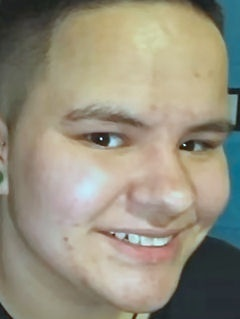

In [9]:
import cv2
from google.colab.patches import cv2_imshow

train_image = cv2.imread(random_train_img_path)
cv2_imshow(train_image)

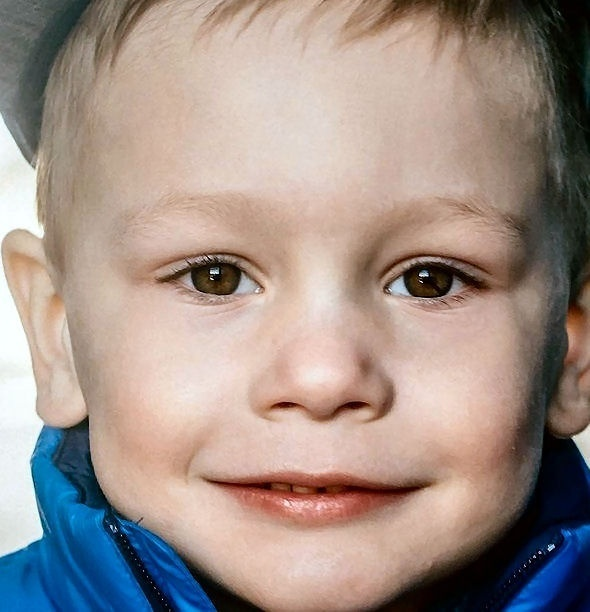

In [10]:
test_image = cv2.imread(random_test_img_path)
cv2_imshow(test_image)

In [11]:
# Download link: https://github.com/davisking/dlib-models
#!bunzip2 shape_predictor_68_face_landmarks.dat.bz2
#!bunzip2 shape_predictor_68_face_landmarks_GTX.dat.bz2

In [12]:
import dlib
import time

class FeatureExtractor:
    def __init__(self, img_dir=None, predictor_model='shape_predictor_68_face_landmarks.dat'):
        # Configuring image directory
        self.img_dir = img_dir
        self.img_paths = self._load_img_paths()

        # Initialize the face detector and facial landmarks predictor from dlib
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(predictor_model)

        self.failed_images = []

    def _load_img_paths(self):
        if self.img_dir == None:
            return None

        img_search_path = os.path.join(self.img_dir, '*')
        return glob.glob(img_search_path)

    def _extract_features_from_image(self, img_path):

        # Extract info from the image path
        file_name = os.path.basename(img_path)
        label, image_num_str, _ = file_name.split('.')
        image_num = int(image_num_str)

        # Read image and process it to detect face landmarks
        image = cv2.imread(img_path)
        image_height = image.shape[0]
        image_width = image.shape[1]

        # Dlib model is trained on GRAY scale image.
        # Hence converting the color image to GRAY scale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect face in the input image
        detected_faces = self.detector(image)

        # No faces detected
        if not detected_faces:
            print(f'No face detected in the image: {file_name}')
            return None

        if len(detected_faces) > 1:
            print(f'Warning: More than one face detected in the input image: {file_name}')

        # Start collecting image features
        curr_img_feature = {
            "img_path": img_path,
            "image_num": image_num,
            "label": label
        }

        # Detect the landmarks for the first detected face
        landmarks = self.predictor(image, detected_faces[0])

        # Detect the landmarks for only one face from the image
        # Our dataset contains only one face per image
        for idx in range(0, 68):
            key_x = f"landmark_{idx}_x"
            key_y = f"landmark_{idx}_y"

            # Convert to normalized coordinates
            landmark_x = (landmarks.part(idx).x) / image_width
            landmark_y = (landmarks.part(idx).y) / image_height

            curr_img_feature[key_x] = landmark_x
            curr_img_feature[key_y] = landmark_y

        return curr_img_feature

    def get_features(self, img_paths=None):
        all_features = []

        if img_paths == None:
            img_paths = self.img_paths

        if img_paths == None:
            print('Configure the image path before extracting the features!')
            return None

        for img_path in img_paths:
            features = self._extract_features_from_image(img_path)
            if features:
                all_features.append(features)
            else:
                print(f"Failed to detect facial landmarks for image: {img_path}")
                self.failed_images.append(img_path)
        return all_features

In [13]:
train_extractor = FeatureExtractor(train_dir)
train_features = train_extractor.get_features()

test_extractor = FeatureExtractor(test_dir)
test_features = test_extractor.get_features()

No face detected in the image: Autistic.83.jpg
Failed to detect facial landmarks for image: /content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based/../../train/Autistic.83.jpg
No face detected in the image: Autistic.876.jpg
Failed to detect facial landmarks for image: /content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based/../../train/Autistic.876.jpg
No face detected in the image: Autistic.878.jpg
Failed to detect facial landmarks for image: /content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based/../../train/Autistic.878.jpg
No face detected in the image: Autistic.856.jpg
Failed to detect facial landmarks for image: /content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based/../../train/Autistic.856.jpg
No face detected in the image: Autistic.866.jpg
Failed to detect facial landmarks for image: /content/drive/MyDrive/Magnimind/Face_detection/Dlib/HOG_based/../../train/Autistic.866.jpg
No face detected in the image: Autistic.879.jpg
Failed to detect facial landm

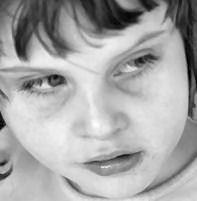

In [31]:
failed_train_image = cv2.imread(random.choice(train_extractor.failed_images), cv2.IMREAD_GRAYSCALE)
cv2_imshow(failed_train_image)

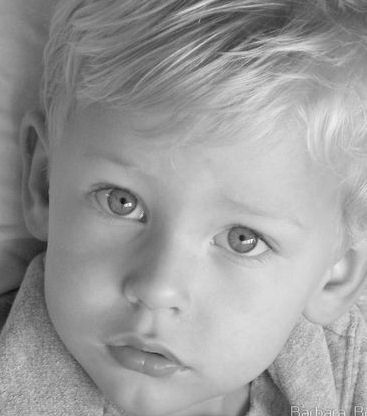

In [32]:
failed_test_image = cv2.imread(random.choice(test_extractor.failed_images), cv2.IMREAD_GRAYSCALE)
cv2_imshow(failed_test_image)

In [16]:
import pandas as pd
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [17]:
train_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
0,/content/drive/MyDrive/Magnimind/Face_detectio...,839,Autistic,0.165049,0.376569,0.169903,0.464435,0.179612,0.548117,0.184466,...,0.553398,0.723849,0.650485,0.702929,0.548544,0.774059,0.504854,0.778243,0.461165,0.765690
1,/content/drive/MyDrive/Magnimind/Face_detectio...,825,Autistic,0.227119,0.524691,0.240678,0.592593,0.254237,0.657407,0.274576,...,0.586441,0.753086,0.654237,0.762346,0.589831,0.783951,0.559322,0.787037,0.528814,0.780864
2,/content/drive/MyDrive/Magnimind/Face_detectio...,817,Autistic,0.092511,0.498168,0.110132,0.578755,0.132159,0.652015,0.154185,...,0.466960,0.758242,0.572687,0.772894,0.466960,0.820513,0.427313,0.824176,0.383260,0.813187
3,/content/drive/MyDrive/Magnimind/Face_detectio...,845,Autistic,0.153169,0.513055,0.161972,0.593995,0.176056,0.672324,0.193662,...,0.575704,0.802872,0.665493,0.809399,0.579225,0.869452,0.528169,0.873368,0.477113,0.866841
4,/content/drive/MyDrive/Magnimind/Face_detectio...,844,Autistic,0.174515,0.582500,0.196676,0.655000,0.224377,0.725000,0.252078,...,0.562327,0.787500,0.653740,0.770000,0.567867,0.820000,0.531856,0.832500,0.495845,0.835000


In [18]:
test_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
0,/content/drive/MyDrive/Magnimind/Face_detectio...,100,Autistic,0.098039,0.454128,0.122549,0.564220,0.142157,0.674312,0.181373,...,0.750000,0.752294,0.813725,0.756881,0.750000,0.761468,0.720588,0.766055,0.686275,0.766055
1,/content/drive/MyDrive/Magnimind/Face_detectio...,108,Autistic,0.059524,0.483871,0.083333,0.575269,0.101190,0.661290,0.125000,...,0.511905,0.720430,0.619048,0.720430,0.517857,0.833333,0.464286,0.849462,0.410714,0.844086
2,/content/drive/MyDrive/Magnimind/Face_detectio...,1,Autistic,0.073427,0.444586,0.069930,0.526115,0.069930,0.607643,0.082168,...,0.493007,0.774522,0.617133,0.791083,0.487762,0.830573,0.438811,0.831847,0.382867,0.821656
3,/content/drive/MyDrive/Magnimind/Face_detectio...,103,Autistic,0.157068,0.396018,0.136126,0.464602,0.123037,0.535398,0.109948,...,0.395288,0.752212,0.492147,0.767699,0.390052,0.752212,0.356021,0.747788,0.327225,0.738938
4,/content/drive/MyDrive/Magnimind/Face_detectio...,107,Autistic,0.104072,0.327068,0.108597,0.436090,0.122172,0.541353,0.149321,...,0.674208,0.729323,0.782805,0.710526,0.669683,0.774436,0.610860,0.789474,0.552036,0.781955


In [19]:
train_df.shape

(1874, 139)

In [20]:
test_df.shape

(274, 139)

In [21]:
train_df['label'].value_counts()

Autistic        1139
Non_Autistic     735
Name: label, dtype: int64

In [22]:
train_df['label'].value_counts(normalize=True)

Autistic        0.607791
Non_Autistic    0.392209
Name: label, dtype: float64

In [23]:
test_df['label'].value_counts()

Non_Autistic    140
Autistic        134
Name: label, dtype: int64

In [24]:
train_df[train_df.isna().any(axis=1)]

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y


In [25]:
train_df.to_csv('train_2D.csv', index=False)
test_df.to_csv('test_2D.csv', index=False)

## Visualizing key facial landmarks from train and test

In [26]:
import math
import numpy as np

# Convert relative to absolute coordinates
def convert_relative_to_absolute_coordinates(normalized_x, normalized_y, image_width, image_height):

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value):
        return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and
            is_valid_normalized_value(normalized_y)):
        return None

    # Limiting the absolute co-ordinates value to width/height of the image
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)

    return x_px, y_px

In [27]:
def visualize_output(img_path, landmarks):
    # Read Image
    image = cv2.imread(img_path)
    height, width, _ = image.shape

    for landmark in landmarks:
        landmark_px = convert_relative_to_absolute_coordinates(landmark[0], landmark[1], width, height)
        cv2.circle(image, landmark_px, 1, (255, 0, 0), -1)

    cv2_imshow(image)

In [28]:
def get_sample_image_and_landmarks(df):
    random_index = df.sample(1).index
    selected_row = df.loc[random_index].iloc[0]

    # Detect the number of landmarks based on the column names
    landmark_cols = [col for col in selected_row.index if "landmark_" in col and "_x" in col]
    num_landmarks = len(landmark_cols)
    print(f'Number of detected landmarks: {num_landmarks}')

    # Extract landmarks
    landmarks = [(selected_row[f'landmark_{i}_x'], selected_row[f'landmark_{i}_y']) for i in range(num_landmarks)]

    sample_img_path = str(selected_row['img_path'])

    return sample_img_path, landmarks

Number of detected landmarks: 68


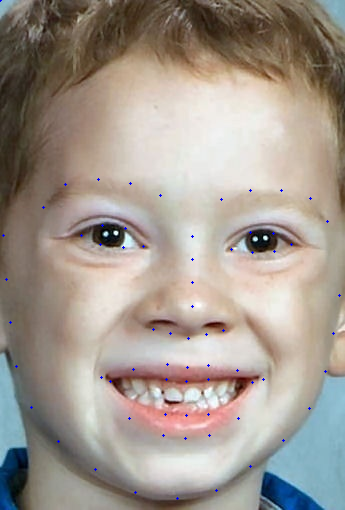

In [29]:
sample_train_img_path, landmarks = get_sample_image_and_landmarks(train_df)
visualize_output(sample_train_img_path, landmarks)

Number of detected landmarks: 68


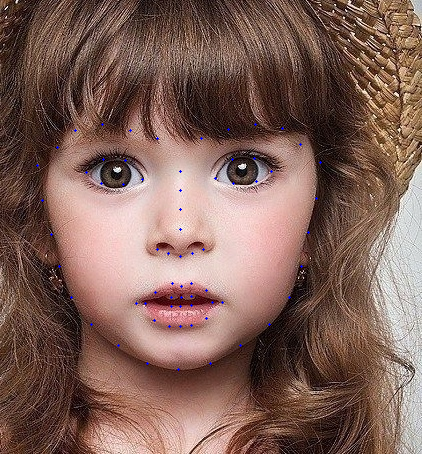

In [30]:
sample_test_img_path, landmarks = get_sample_image_and_landmarks(test_df)
visualize_output(sample_test_img_path, landmarks)